<a href="https://colab.research.google.com/github/aj-39719/Deep-Learning-ST456/blob/main/Data_Science_Weekend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [ ]:
import csv
import networkx as nx
import scipy as np
import numpy as np
import pandas as pd

# **Loading the data set**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('drive/My Drive/Colab Notebooks/')

Mounted at /content/drive


In [ ]:
### Importing data as pandas dataframe
arcs = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bis_arcs-1.csv")
vertices = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bis_vertices-1.csv")

print(vertices.shape)
print(vertices.columns)
print(arcs.shape)
print(arcs.columns)

(1536, 3)
Index(['net_id', 'vertex_id', 'country'], dtype='object')
(27377, 4)
Index(['net_id', 'from_id', 'to_id', 'value'], dtype='object')


# **Data Manipuation**

In [ ]:
### Right join the vertices dataframe on arcs dataframe, using the "net_id" & "vertex_id" columns and "net_id" and "to_id" respectively
df = vertices.merge(arcs, how="right", left_on=["net_id","vertex_id"],right_on=["net_id","to_id"])
print(df.shape)
df.head()

(27377, 6)


,net_id,vertex_id,country,from_id,to_id,value
0,2005-06-30,5A,All reporting countries,AU,5A,297278.0
1,2005-06-30,AT,Austria,AU,AT,1587.0
2,2005-06-30,BE,Belgium,AU,BE,5312.0
3,2005-06-30,TW,Chinese Taipei,AU,TW,2350.0
4,2005-06-30,FR,France,AU,FR,25460.0


In [ ]:
### Drop rows with vertex_id '5A' to avoid double-counting 

df.drop(df[df["vertex_id"] == "5A"].index, inplace = True)
print(df.shape)
df.head()

(25969, 6)


,net_id,vertex_id,country,from_id,to_id,value
1,2005-06-30,AT,Austria,AU,AT,1587.0
2,2005-06-30,BE,Belgium,AU,BE,5312.0
3,2005-06-30,TW,Chinese Taipei,AU,TW,2350.0
4,2005-06-30,FR,France,AU,FR,25460.0
5,2005-06-30,DE,Germany,AU,DE,27456.0


In [ ]:
### Replace net_id with integers, such that the 1st quarter will be 0, 2nd quarter will be 1 and so on

dates = pd.unique(df["net_id"])
count = list(range(dates))
replacements = dict(zip(dates,count))
df.replace(replacements, inplace= True)

In [ ]:
### Sort the values so that we can see the values for each arc every quarter

df.sort_values(['from_id','to_id','net_id'], inplace = True)
df.head()

,net_id,vertex_id,country,from_id,to_id,value
17,0,AU,Australia,AT,AU,541.0
394,1,AU,Australia,AT,AU,684.0
771,2,AU,Australia,AT,AU,930.0
1148,3,AU,Australia,AT,AU,564.0
1539,4,AU,Australia,AT,AU,659.0


In [ ]:
### Calculate the percentage changes over each quarter

changes = df['value'].pct_change()
df['percentage_changes'] = changes
df.iloc[63:65,]

,net_id,vertex_id,country,from_id,to_id,value,percentage_changes
26951,63,AU,Australia,AT,AU,248.199,-0.022592
18,0,BE,Belgium,AT,BE,6652.000,25.801075


Howver, the percentage_changes for the 2nd row above should be NaN since there was no information about the previous quarter of the AT-BE arc. Hence we will set all percentage_changes to NaN when net_id == 0. 

In [ ]:
### Set the first instance of percentage_changes of each arc to NaN, since there is no previous value to compare against. 

df.loc[df['net_id'] == 0, 'percentage_changes'] = np.NaN

df.iloc[63:65,]

,net_id,vertex_id,country,from_id,to_id,value,percentage_changes
26951,63,AU,Australia,AT,AU,248.199,-0.022592
18,0,BE,Belgium,AT,BE,6652.000,NaN


In [ ]:
### Looking at a particular arc, e.g. US-GB

df_us = df[df['from_id'] == 'US']
df_us_gb = df_us[df_us['to_id'] == 'GB']

In [ ]:
x = df_us_gb['net_id']
y = df_us_gb['percentage_changes']

In [ ]:
rmean = df_us_gb['percentage_changes'].rolling(4).mean()
rstd = df_us_gb['percentage_changes'].rolling(4).std()

# **Data Visualization**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


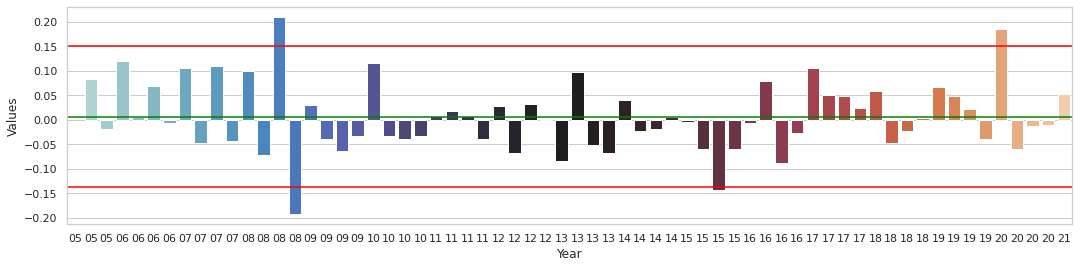

In [ ]:
sns.set(rc={"figure.figsize":(18, 4)})
sns.set_theme(style="whitegrid")
ax = sns.barplot(x,y, palette="icefire");
lbl = ["05"]*3  + ["06"]*4 + ["07"]*4 + ["08"]*4 + ["09"]*4 + ["10"]*4 + ["11"]*4 + ["12"]*4 + ["13"]*4 + ["14"]*4 + ["15"]*4 + ["16"]*4 + ["17"]*4 + ["18"]*4 + ["19"]*4 + ["20"]*4 + ["21"]
ax.axhline(rmean, color = "green")
ax.axhline(rmean + 2*rstd, color = "red")
ax.axhline(rmean - 2*rstd, color = "red")
ax.set(xlabel = "Year" , ylabel = "Values");

ax.set_xticklabels(lbl);


***The Mean is above 0 indicating the value has increased over the years.***

***There are 4 instances of anomalies over the last 15 years.***

#**Plotting the distribution of percentile changes**

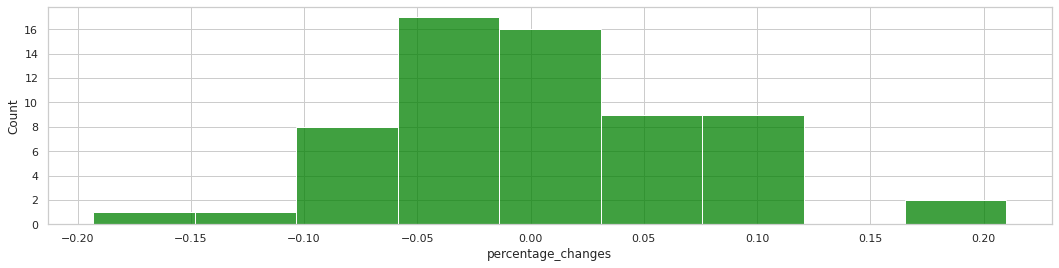

In [ ]:
sns.set(rc={"figure.figsize":(18, 4)})
sns.set_theme(style="whitegrid")
ax = sns.histplot(data=y, color="green");

***Hence, we see the distribution of percentage change is normally distributed***

# **Final Comments**

This model can be scaled to analyze values for any two country pairs and see the anomalies.

It is also straightforward to change Threshold values as different countries have different scenarios and cant be analyzed on the same level of threshold.